# OPM Example (Parcel Level)

Start-to-end example script for applying the canonical HMM to OPM data.

#### Input Data

We will use data in BIDS format:
```
BIDS/
├── ...
├── sub-03/
│   ├── meg/
│   │   ├── sub-03_task-movie_run-01_meg.mat
│   │   ├── sub-03_task-movie_run-01_channels.tsv
│   │   ├── ...
│   ├── anat/
│   │   ├── sub-03_T1w.nii
│   │   └── ...
├── ...
```
And write output to the `BIDS/derivatives` directory.

#### Steps

1. Preprocessing:
    - We clean the sensor-level OPM data and save the output to `BIDS/derivatives/preprocessed`.

2. Surface Extraction:
    - We will extract surfaces using FSL from a structural MRI and save to `BIDS/derivatives/anat_surfaces`.

3. Coregistration:
    - We will coregister the OPM and with structural MRI using Polhemus headshape points/fiducials and the surfaces from the MRI.
    - We will also compute the forward model.

4. Source Reconstruction (LCMV Beamformer):
    - We will compute a volumetric LCMV beamformer and apply it to the cleaned sensor data to get data in a voxel grid.

5. Parcellation:
    - We will parcel the data and orthogonalise to remove spatial leakage.
    - The output of steps 2-5 will be saved to `BIDS/derivatives/osl`.

6. Prepare Data for the Canonical HMM:
    - We will perform dipole sign flipping, time-delay embedding, PCA and standardisation to prepare the parcel data for the canonical HMM.

7. Fit the Canonical HMM:
    - We will apply the canonical HMM to the prepared data.

8. HMM Post-Hoc Analysis:
    - Estimate state-specific quantities of interest, such as spectral properties, networks, and summary statistics for dynamics.
    - The output will be saved to `BIDS/derivatives/hmm`.

 Although we provide a single start-to-end example script, it is possible to separate the different steps. E.g. you may wish to do all the preprocessing (for different sessions) in a script then have a separate script for the coregistration, source reconstruction and parcellation, as well as a different script for the HMM.

#### Import Packages

In [1]:
import os
import numpy as np
from pathlib import Path

import mne
mne.viz.set_3d_backend("notebook")

from modules import preproc, rhino, source_recon, parcellation, hmm, utils

from osl_dynamics import inference, analysis
from osl_dynamics.utils import plotting
from osl_dynamics.data import Data

Using notebook 3d backend.


2026-01-02 11:17:02.090735: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Session Info

Let's specify which session in the `BIDS` directory we wish to study.

In [2]:
subject = "03"
task = "movie"
run = "01"
id = f"sub-{subject}_task-{task}_run-{run}"
print("id:", id)

id: sub-03_task-movie_run-01


## 0. Convert OPM Files

First we need to convert the OPM files (we got from Nottingham University) into fif format.

In [3]:
# Output fif file for the OPM data
opm_fif_dir = "BIDS/derivatives/opm_raw_fif"
os.makedirs(opm_fif_dir, exist_ok=True)
raw_file = f"{opm_fif_dir}/{id}_raw.fif"

# We also need to fix the sform in the structurals from Nottingham
fixed_smri_dir = "BIDS/derivatives/fixed_smri"
os.makedirs(fixed_smri_dir, exist_ok=True)
smri_file = f"{fixed_smri_dir}/sub-{subject}_T1w.nii"

utils.convert_notts_opm_files_to_fif(
    mat_file=f"BIDS/sub-{subject}/meg/{id}_meg.mat",
    smri_file=f"BIDS/sub-{subject}/anat/sub-{subject}_T1w.nii",
    tsv_file=f"BIDS/sub-{subject}/meg/{id}_channels.tsv",
    out_fif_file=raw_file,
    out_fixed_smri_file=smri_file,
)

fslorient -setsform 1.0 0.0 0.0 -90.0 0.0 -1.0 0.0 126.0 0.0 0.0 -1.0 72.0 0.0 0.0 0.0 1.0 BIDS/derivatives/fixed_smri/sub-03_T1w.nii


/Users/gohil/Desktop/Canonical-HMM-Networks/modules/utils.py:210: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  info.set_montage(dig_montage)


Creating RawArray with float64 data, n_channels=168, n_times=791280
    Range : 0 ... 791279 =      0.000 ...   659.399 secs
Ready.
Writing /Users/gohil/Desktop/Canonical-HMM-Networks/BIDS/derivatives/opm_raw_fif/sub-03_task-movie_run-01_raw.fif
Closing /Users/gohil/Desktop/Canonical-HMM-Networks/BIDS/derivatives/opm_raw_fif/sub-03_task-movie_run-01_raw.fif
[done]


## 1. Preprocessing

Now, we can clean the sensor data. We will use MNE to do this. Let's load the raw fif file.

In [4]:
raw = mne.io.read_raw_fif(raw_file, preload=True)

Opening raw data file BIDS/derivatives/opm_raw_fif/sub-03_task-movie_run-01_raw.fif...
    Range : 0 ... 791279 =      0.000 ...   659.399 secs
Ready.
Reading 0 ... 791279  =      0.000 ...   659.399 secs...


Now, let's perform some minimal preprocessing: filtering, downsampling and bad segment/channel detection.

In [5]:
raw = raw.filter(l_freq=4, h_freq=40, method="iir", iir_params={"order": 5, "ftype": "butter"})
raw = raw.resample(sfreq=250)
raw = preproc.detect_bad_segments(raw, picks="mag", significance_level=0.1)
raw = preproc.detect_bad_segments(raw, picks="mag", mode="diff", significance_level=0.1)
raw = preproc.detect_bad_segments(raw, picks="mag", metric="kurtosis", significance_level=0.1)
raw = preproc.detect_bad_channels(raw, picks="mag", significance_level=0.1)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB


Bad segment detection
---------------------
Modality: mag
Mode: None
Metric: std
Significance level: 0.1
Maximum fraction: 0.1
Found 5 bad segments: 22.0/659.4 seconds rejected (3.3%)

Bad segment detection
---------------------
Omitting 5500 of 164850 (3.34%) samples, retaining 159350 (96.66%) samples.
Modality: mag
Mode: diff
Metric: std
Significance level: 0.1
Maximum fraction: 0.1
Found 0 bad segments: 0.0/659.4 seconds rejected (0.0%)

Bad segment detection
---------------------
Omitting 5500 of 164850 (3.34%) samples, retaining 159350 (96.66%) samples.
Modality: mag
Mode: None
Metric: kurtosis
Significance level: 0.1
Maximum fraction: 0.1
Found 4 bad segments: 14.0/659.4 

/Users/gohil/Desktop/Canonical-HMM-Networks/modules/preproc.py:286: RuntimeWarning: invalid value encountered in scalar divide
  R[j] = R[j] / np.nanstd(temp)


And finally we save the preprocessed data.

In [6]:
preproc_file = Path(f"BIDS/derivatives/preprocessed/{id}_preproc-raw.fif")
preproc_file.parent.mkdir(parents=True, exist_ok=True)
raw.save(preproc_file, overwrite=True)

Writing /Users/gohil/Desktop/Canonical-HMM-Networks/BIDS/derivatives/preprocessed/sub-03_task-movie_run-01_preproc-raw.fif
Closing /Users/gohil/Desktop/Canonical-HMM-Networks/BIDS/derivatives/preprocessed/sub-03_task-movie_run-01_preproc-raw.fif
[done]


[PosixPath('/Users/gohil/Desktop/Canonical-HMM-Networks/BIDS/derivatives/preprocessed/sub-03_task-movie_run-01_preproc-raw.fif')]

## 2. Surface Extraction

First we extract surfaces (inskull, outskull and outskin) from the structural MRI. Note, if you do not have a structural MRI we can skip this step and use a standard (MNI152) brain (see below).


Extracting surfaces
-------------------
Reorienting brain to be RADIOLOGICAL
You can use the following command line call to check the sMRI is appropriate, including checking that the L-R, S-I, A-P labels are sensible:
fsleyes BIDS/derivatives/anat_surfaces/sub-03/smri.nii.gz /Users/gohil/packages/fsl/data/standard/MNI152_T1_1mm_brain.nii.gz
Running BET pre-FLIRT...
Running FLIRT...
Running BET and BETSURF...
Cleaning up flirt files
Saving BIDS/derivatives/anat_surfaces/sub-03/inskull.png
Saving BIDS/derivatives/anat_surfaces/sub-03/outskull.png
Saving BIDS/derivatives/anat_surfaces/sub-03/outskin.png
Surface extraction complete.


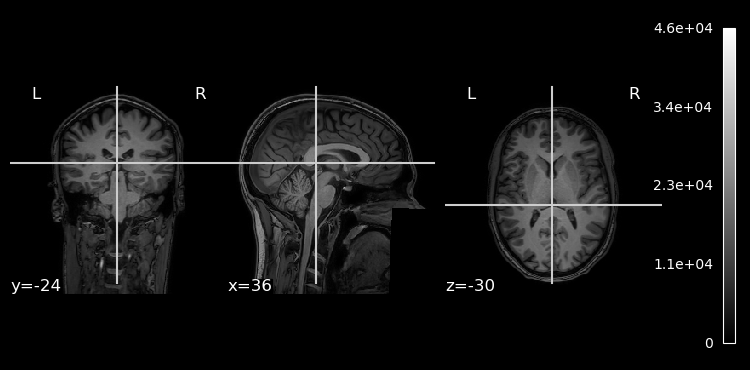

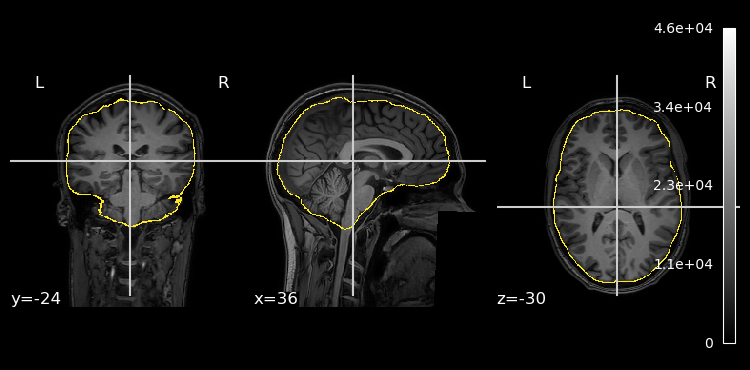

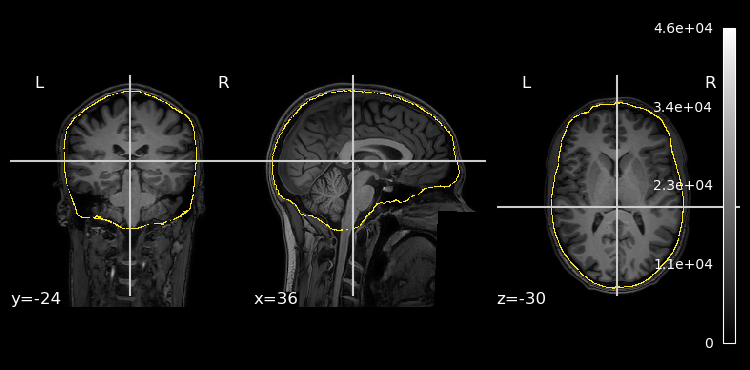

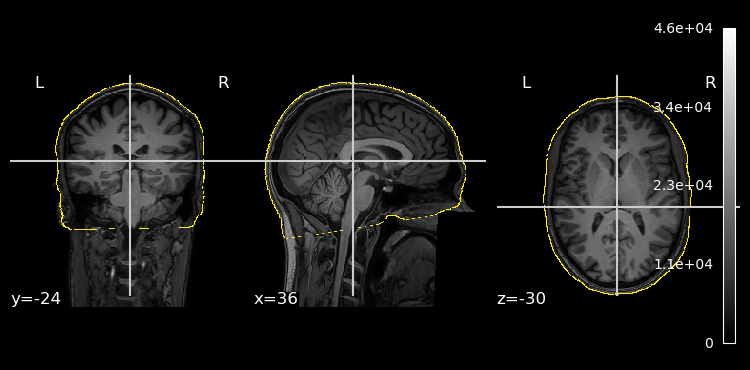

In [7]:
rhino.extract_surfaces(
    smri_file=smri_file,
    outdir=f"BIDS/derivatives/anat_surfaces/sub-{subject}",
)

The above plots are:
1. The structural MRI
2. The inskull surface (yellow line).
3. The outskull surface (yellow line).
4. The outskin surface (yellow line).

If these surfaces don't match the corresponding surface in the structural MRI, then these needs to be fixed before moving on. Alternatively, we can use a standard (MNI152) brain.

## OSL Output Files

Now we have the preprocessed sensor data and the MRI surfaces. We can perform an 'OSL' source reconstruction. This involves creating many files. Let's create an object (container) to keep track of all the files.

In [8]:
fns = utils.OSLFilenames(
    outdir="BIDS/derivatives/osl",
    id=id,
    preproc_file=f"BIDS/derivatives/preprocessed/{id}_preproc-raw.fif",
    surfaces_dir=f"BIDS/derivatives/anat_surfaces/sub-{subject}",
)
print(fns)

OSLFilenames for sub-03_task-movie_run-01:
  Output directory:  BIDS/derivatives/osl
  Preprocessed file: BIDS/derivatives/preprocessed/sub-03_task-movie_run-01_preproc-raw.fif
  Surfaces directory: BIDS/derivatives/anat_surfaces/sub-03
  BEM directory:     BIDS/derivatives/osl/sub-03_task-movie_run-01/bem
  Coreg directory:   BIDS/derivatives/osl/sub-03_task-movie_run-01/coreg
    └─ Forward model: BIDS/derivatives/osl/sub-03_task-movie_run-01/coreg/model-fwd.fif
  Source directory:  BIDS/derivatives/osl/sub-03_task-movie_run-01/src
    └─ lcmv filters:  BIDS/derivatives/osl/sub-03_task-movie_run-01/src/filters-lcmv.h5


There are some files which we have already generated like the preprocessed fif file and the surfaces. Other files we will create in the following steps.

Now let's extract the Polhemus from the preprocessed fif file and coregister the MEG and MRI.

## 3. Coregistration

Next we use the Polhemus headshape points/fiducials to coregister the MEG and structural MRI.


Extracting polhemus from fif info
---------------------------------
Saved: BIDS/derivatives/osl/sub-03_task-movie_run-01/coreg/polhemus_nasion.txt
Saved: BIDS/derivatives/osl/sub-03_task-movie_run-01/coreg/polhemus_rpa.txt
Saved: BIDS/derivatives/osl/sub-03_task-movie_run-01/coreg/polhemus_lpa.txt
Saved: BIDS/derivatives/osl/sub-03_task-movie_run-01/coreg/polhemus_headshape.txt

Running coregistration
----------------------
Creating RawArray with float64 data, n_channels=168, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.
Writing /Users/gohil/Desktop/Canonical-HMM-Networks/BIDS/derivatives/osl/sub-03_task-movie_run-01/coreg/info-raw.fif
Closing /Users/gohil/Desktop/Canonical-HMM-Networks/BIDS/derivatives/osl/sub-03_task-movie_run-01/coreg/info-raw.fif
[done]
Plotting coregistration
Overwriting existing file.
Saving view frontal -> BIDS/derivatives/osl/sub-03_task-movie_run-01/coreg/coreg_frontal.png
Saving view right -> BIDS/derivatives/osl/sub-03_task-movie_run-

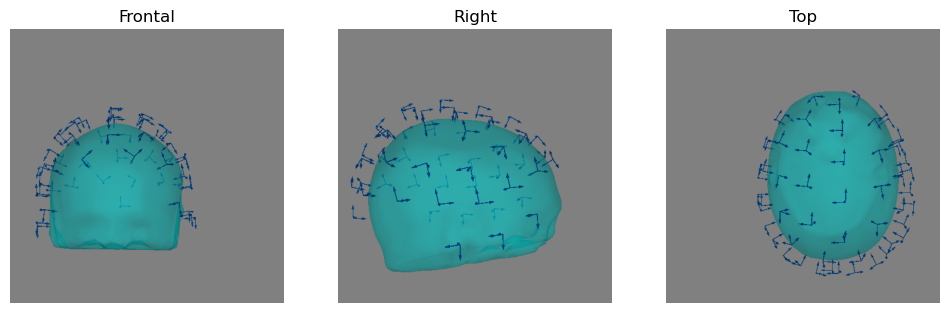

In [9]:
rhino.extract_polhemus_from_fif(fns)
rhino.coregister(fns, already_coregistered=True)

If the coregistration looks off we need to fix it before moving on. Some things we can try:
- Remove stray Polhemus headshape points with `rhino.remove_shape_headshape_points`.
- Tweak the headshape points and/or fiducials (these are in text files in `fns.coreg_dir`).
- Not use the headshape points.

Next, we calculate the forward model for MEG. Here, we're using a 'Single Layer' (Single Shell) head model and a dipole grid resolution of 8mm.

In [10]:
rhino.forward_model(fns, model="Single Layer", gridstep=8)


Calculating forward model
-------------------------
Using bet_inskull_surf_file for single shell surface
Surface CM = (  36.3  -20.5  -30.5) mm
Surface fits inside a sphere with radius   99.5 mm
Surface extent:
    x =  -31.4 ...  103.7 mm
    y = -106.1 ...   78.2 mm
    z = -101.6 ...   36.8 mm
Grid extent:
    x =  -32.0 ...  104.0 mm
    y = -112.0 ...   80.0 mm
    z = -104.0 ...   40.0 mm
8550 sources before omitting any.
6599 sources after omitting infeasible sources not within 0.0 - 99.5 mm.
Source spaces are in MRI coordinates.
Checking that the sources are inside the surface and at least    4.0 mm away (will take a few...)
Checking surface interior status for 6599 points...
    Found  660/6599 points inside  an interior sphere of radius   43.4 mm
    Found    0/6599 points outside an exterior sphere of radius   99.5 mm
    Found 3238/5939 points outside using surface Qhull
    Found  249/2701 points outside using solid angles
    Total 3112/6599 points inside the surface
Int

## 4. Source Reconstruction

Now we are ready to create an LCMV beamformer. We will use a unit-noise-gain-invariant beamformer. Note, the rank of Elekta MEG data is <64 due to MaxFiltering.

In [11]:
source_recon.lcmv_beamformer(fns, raw, chantypes="mag", rank={"mag": 100})


Making LCMV beamformer
----------------------
Reading forward solution from /Users/gohil/Desktop/Canonical-HMM-Networks/BIDS/derivatives/osl/sub-03_task-movie_run-01/coreg/model-fwd.fif...
    Reading a source space...
    [done]
    1 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read MEG forward solution (2675 sources, 168 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Using up to 3297 segments
Number of samples used : 157350
[done]
Variance for chantype mag is 1.5167864471564534e-25
Computing rank from covariance with rank={'mag': 100}
Computing rank from covariance with rank='info'
    MAG: rank 165 after 0 projectors applied to 165 channels
Making LCMV beamformer with data cov rank {'mag': 100}
Making LCMV beamformer with noise cov rank {'mag': 165}
Computing inverse operator with 165 channels.
    165 out of 168 channels remain after picking
Selected 165 channels
W

Next, we calculate voxel data by applying the beamformer weights to the sensor data. Note, the following function returns the voxel data  (and coordinates) in MNI space.

In [12]:
voxel_data, voxel_coords = source_recon.apply_lcmv_beamformer(fns, raw)


Applying LCMV beamformer
------------------------
Omitting 7500 of 164850 (4.55%) samples, retaining 157350 (95.45%) samples.
Reading forward solution from /Users/gohil/Desktop/Canonical-HMM-Networks/BIDS/derivatives/osl/sub-03_task-movie_run-01/coreg/model-fwd.fif...
    Reading a source space...
    [done]
    1 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read MEG forward solution (2675 sources, 168 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
spatial_resolution = 8 mm
mask_file: BIDS/derivatives/osl/sub-03_task-movie_run-01/src/MNI152_T1_8mm_brain.nii.gz
Finding nearest neighbour in resampled MNI space
Applying LCMV beamformer complete.


## 5. Parcellation

Now we have the voxel data, we can parcellate.

In [13]:
parcellation_file = "Glasser52_binary_space-MNI152NLin6_res-8x8x8.nii.gz"

parcel_data = parcellation.parcellate(
    fns,
    voxel_data,
    voxel_coords,
    method="spatial_basis",
    orthogonalisation="symmetric",
    parcellation_file=parcellation_file,
)

parc_fif = f"BIDS/derivatives/osl/{id}/lcmv-parc-raw.fif"
parcellation.save_as_fif(
    parcel_data,
    raw,
    extra_chans="stim",
    filename=parc_fif,
)

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2026-01-02 11:23:15 INFO nibabel.global [batteryrunners.py:268:log_raise]: pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2026-01-02 11:23:15 INFO nibabel.global [batteryrunners.py:268:log_raise]: pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1



Parcellating data
-----------------
gridstep = 8 mm


Resampled parcellation: BIDS/derivatives/osl/sub-03_task-movie_run-01/src/Glasser52_binary_space-MNI152NLin6_res-8x8x8_8mm.nii.gz
Finding nearest neighbour voxel
Calculating parcel time courses with spatial_basis
Performing symmetric orthogonalisation
Saving BIDS/derivatives/osl/sub-03_task-movie_run-01/lcmv-parc-raw.fif
Omitting 7500 of 164850 (4.55%) samples, retaining 157350 (95.45%) samples.
Creating RawArray with float64 data, n_channels=52, n_times=164850
    Range : 0 ... 164849 =      0.000 ...   659.396 secs
Ready.
No stim channel to add to parc-raw.fif
Writing /Users/gohil/Desktop/Canonical-HMM-Networks/BIDS/derivatives/osl/sub-03_task-movie_run-01/lcmv-parc-raw.fif
Closing /Users/gohil/Desktop/Canonical-HMM-Networks/BIDS/derivatives/osl/sub-03_task-movie_run-01/lcmv-parc-raw.fif
[done]


The final data is saved in the file `lcmv-parc-raw.fif`. The parcellated data is saves as a `'misc'` channel type.

The last thing we will do is plot the PSD of the parcel data to check the source reconstruction looks reasonable.

Opening raw data file BIDS/derivatives/osl/sub-03_task-movie_run-01/lcmv-parc-raw.fif...
Isotrak not found
    Range : 0 ... 164849 =      0.000 ...   659.396 secs
Ready.
Omitting 7500 of 164850 (4.55%) samples, retaining 157350 (95.45%) samples.


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2026-01-02 11:27:39 INFO nibabel.global [batteryrunners.py:268:log_raise]: pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


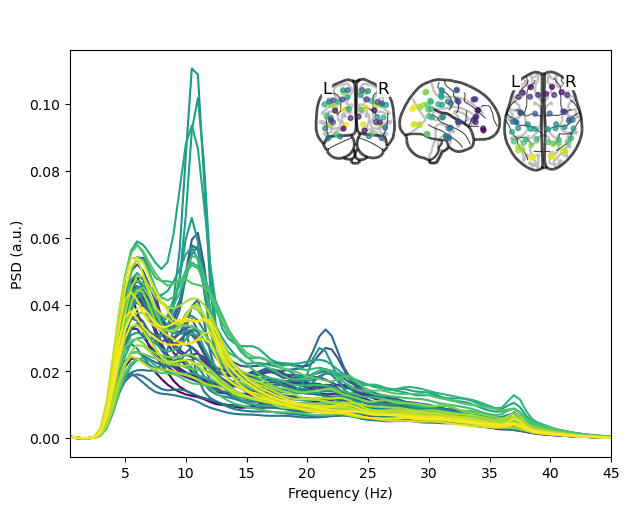

In [14]:
parcellation.plot_psds(parc_fif, parcellation_file=parcellation_file)

We should see alpha (~10 Hz) activity is posterior in the brain if not there may be an issue. Although note, there is a lot of subject variability, some subjects don't exhibit strong alpha oscillations.

## 6. Prepare Data for the Canonical HMM

Here, we prepare the data by aligning the sign of the parcel time courses to the template session from the canonical HMM and then perform time-delay embedding and PCA. Finally, we standardise the data. This is all done with the `prepare_data_for_canonical_hmm` function.

In [15]:
# Load and prepare the data
data = Data(parc_fif, picks="misc", reject_by_annotation="omit")
data = hmm.prepare_data_for_canonical_hmm(data, parcellation="52ROI_Glasser")

# Save
hmm_dir = f"BIDS/derivatives/hmm/{id}"
data.save(hmm_dir)

Loading files:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating covariances:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-02 11:28:12 INFO osl-dynamics [base.py:1175:align_channel_signs]: Aligning channel signs across sessions
2026-01-02 11:29:25 INFO osl-dynamics [base.py:1138:_find_and_apply_flips]: Session 0, Init 0, best correlation with template: 0.109
2026-01-02 11:30:17 INFO osl-dynamics [base.py:1138:_find_and_apply_flips]: Session 0, Init 1, best correlation with template: 0.116
2026-01-02 11:31:11 INFO osl-dynamics [base.py:1138:_find_and_apply_flips]: Session 0, Init 2, best correlation with template: 0.116


TDE-PCA:   0%|          | 0/1 [00:00<?, ?it/s]

Standardize:   0%|          | 0/1 [00:00<?, ?it/s]

Saving data:   0%|          | 0/1 [00:00<?, ?it/s]

## 7. Fit the Canonical HMM

First, we load a canonical HMM.

In [16]:
model = hmm.load_canonical_hmm(n_states=8, parcellation="52ROI_Glasser")
model.summary()

Model: "HMM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, 400, 120)  │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ means               │ (8, 120)          │        960 │ data[0][0]        │
│ (VectorsLayer)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ covs                │ (8, 120, 120)     │     58,080 │ data[0][0]        │
│ (CovarianceMatrice… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ll                  │ (None, 400, 120)  │          0 │ data[0][0],       │
│ (SeparateLogLikeli… │                   │            │ means[0][0],      │
│                     │                   │            │ covs[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hid_state_inf       │ [(None, 400,      │         72 │ ll[0][0]          │
│ (HiddenMarkovState… │ 120), (None, 400, │            │                   │
│                     │ 8, 8)]            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ll_loss             │ (1)               │          0 │ ll[0][0],         │
│ (SumLogLikelihoodL… │                   │            │ hid_state_inf[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 59,112 (230.91 KB)

 Trainable params: 58,152 (227.16 KB)

 Non-trainable params: 960 (3.75 KB)

Now let's infer the probability of each state being active at a given time point in the new data.

2026-01-02 11:31:16 INFO osl-dynamics [inf_mod_base.py:1151:get_alpha]: Getting alpha


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 665ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


2026-01-02 11:31:32.337531: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Writing /Users/gohil/Desktop/Canonical-HMM-Networks/BIDS/derivatives/hmm/sub-03_task-movie_run-01/alp_raw.fif
Closing /Users/gohil/Desktop/Canonical-HMM-Networks/BIDS/derivatives/hmm/sub-03_task-movie_run-01/alp_raw.fif
[done]


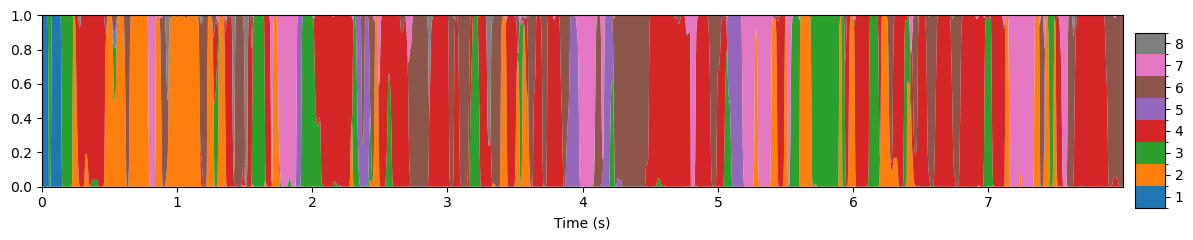

In [17]:
# State probability time course
alp = model.get_alpha(data)

# Save
alp_raw = inference.modes.convert_to_mne_raw(alp, parc_fif, n_embeddings=data.n_embeddings)
alp_raw.save(f"{hmm_dir}/alp_raw.fif", overwrite=True)

# Plot (just the first 8 seconds for visualisation)
fig, ax = plotting.plot_alpha(alp, n_samples=2000, sampling_frequency=250)

## 8. HMM Post-Hoc Analysis

Now we have the state probabilities, we can perform 'post-hoc analysis' where we estimate state-specific quantities of interest such as spectral properties, networks, and summary statistics for dynamics.

See the [osl-dynamics docs](https://osl-dynamics.readthedocs.io/en/latest/documentation.html) for further information and tutorials, as well as code for visualisations.

Let's start with the spectral properties.

In [18]:
# Calculate multitaper
trimmed_data = data.trim_time_series(sequence_length=model.config.sequence_length, prepared=False)
f, psd, coh = analysis.spectral.multitaper_spectra(
    data=trimmed_data,
    alpha=alp,
    sampling_frequency=250,
    frequency_range=[4, 40],
)
print(f.shape)
print(psd.shape)
print(coh.shape)

# Save
np.save(f"{hmm_dir}/f.npy", f)
np.save(f"{hmm_dir}/psd.npy", psd)
np.save(f"{hmm_dir}/coh.npy", coh)

2026-01-02 11:31:33 INFO osl-dynamics [spectral.py:477:multitaper_spectra]: Calculating spectra


(73,)
(8, 52, 73)
(8, 52, 52, 73)


Now let's use the spectra to calculate state-specific networks.

In [19]:
# Power maps
pow_maps = analysis.power.variance_from_spectra(f, psd)
print(pow_maps.shape)
np.save(f"{hmm_dir}/pow_maps.npy", pow_maps)

# Coherence networks
coh_nets = analysis.connectivity.mean_coherence_from_spectra(f, coh)
print(coh_nets.shape)
np.save(f"{hmm_dir}/coh_nets.npy", coh_nets)

(8, 52)
(8, 52, 52)


Finally, let's calculate summary statistics for dynamics.

In [20]:
# Binarise the state probabilities
stc = inference.modes.argmax_time_courses(alp)

# Summary statistics
fo = analysis.post_hoc.fractional_occupancies(stc)
lt = analysis.post_hoc.mean_lifetimes(stc, sampling_frequency=250)
intv = analysis.post_hoc.mean_intervals(stc, sampling_frequency=250)
sr = analysis.post_hoc.switching_rates(stc, sampling_frequency=250)

# Save
np.save(f"{hmm_dir}/fo.npy", fo)
np.save(f"{hmm_dir}/lt.npy", lt)
np.save(f"{hmm_dir}/intv.npy", intv)
np.save(f"{hmm_dir}/sr.npy", sr)